- 메뉴 : 런타임 > 런타임 유형변경 ==> GPU
사용여부 설정.
- 단축키 == 쥬피터 노트북과 동일.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Thu Feb 23 05:52:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |    838MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Convolutional Neural Network 구현

- MNIST 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교 해본다.

##### 학습결과 시각화 함수 정의

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import numpy as np
import matplotlib.pyplot as plt

import os
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
tf.__version__, keras.__version__, np.__version__

('2.11.0', '2.11.0', '1.22.4')

In [ ]:
def plot_result(hist, loss_min=None, loss_max=None):
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(hist.epoch, hist.history['loss'], label='Train Loss')
    plt.plot(hist.epoch, hist.history['val_loss'], label='Validation Loss')
    plt.title("Loss")
    if loss_min!=None and loss_max!=None:
        plt.ylim(loss_min, loss_max)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.epoch, hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.epoch, hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# MNIST CNN 적용

##### data loading

In [ ]:
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
train_image.shape, test_image.shape

((60000, 28, 28), (10000, 28, 28))

##### 전처리, Dataset 생성
- X
    - uint8을 float32 타입으로 변경.
    - pixcel값 정규화: 0 ~ 1
    - Gray scale에 channel 축이 없는 경우 dummy 축을 늘려준다.
        - 영상처리 convolution layer(Conv2D)는 입력으로 3차원 (height, width, channel) 배열을 받는다.
- Y: onehot encoding

In [ ]:
# input 전처리
X_train = train_image.astype('float32')/255
X_train = X_train[..., np.newaxis] # reshape(28,28,-1)

X_test = test_image.astype('float32')/255
X_test = X_test[..., np.newaxis]

print(X_train.dtype, X_test.dtype)
print(X_train.shape, X_test.shape)


float32 float32
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
# output 전처리  -> OneHot Encoding
y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)

print(train_label.shape, y_train.shape)
print(test_label.shape, y_test.shape)


(60000,) (60000, 10)
(10000,) (10000, 10)


##### 하이퍼파라미터, 변수 설정

In [ ]:
LEARNING_RATE=0.001
N_EPOCH = 20
N_BATCH = 1000

N_TRAIN = X_train.shape[0]

###### Dataset 생성

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                               .shuffle(N_TRAIN)\
                               .batch(N_BATCH, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH)

## Model(Network) 정의
- Feature Extraction(backbone):Convolution Layer
    - block: Convolution + MaxPooling Layer
    - size(height, width) 는 줄이고 channel은 늘리는 방향으로 Layer들을 쌓는다.
    - convolution
        - size: 3 X 3
        - strides: 1
    - max pooling
        - size: 2 X 2
        - strides: 2
        - 위와 같이 지정해 input의 size를 절반으로 줄인다. 
- 분류기
    - Dense Layer 사용        
    - Flatten을 먼저 해야 한다. (Conv의 output-feature map- 3차원 배열)


In [ ]:
# %%writefile model.py
def get_mnist_cnn_model(lr=0.01):
    model = keras.Sequential()
    # Input Layer
    model.add(layers.InputLayer(input_shape=(28, 28, 1)))  # Convolution Layer의 Input은 3차원 (height, width, channel)

    # Feature Extractor -> Convolution Block (Conv + MaxPool)
    model.add(layers.Conv2D(filters=16,         # 레이어의 필터 개수.
                           kernel_size=(3,3),  # 필터의 크기(height, width). height와 width가 같은 경우 정수로 지정.
                           strides=(1,1),      # stride 지정 (좌우, 상하) 이동크기.(기본: (1, 1)). 두 값이 같은 경우 정수
                           padding='same',     # 패딩방식 - "same": input/output의 shape이 같도록 처리. "valid"-기본값: 패딩 안씀
                           activation='relu'   # 활성함수.
                           ))
    # MaxPooing Layer을 이용해서 Feature map의 size를 줄여준다. 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), # Max값을 추출할 영역의 크기(height, width) => 기본: (2, 2) => 절반으로 줄인다.
                                  strides=(2, 2),   # 이동 간격. 튜플:(좌우, 상하) 정수: 두값이 같은 경우 정수로 설정. 기본값: pool_size와 동일하게 잡아준다.(겹치지 않도록 하기 위해.)
                                  padding="same"    # "same": 추출하려는 영역의 크기가 pool_size보다 작아도 max값을 추출.
                                  ))                # "valid" (기본): 추출하려는 영역의 크기가 pool_size보다 작으면 max값을 추출하지 않는다.

    model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))
    # Filter Map(3차원) -> 1차원으로 reshape
    model.add(layers.Flatten())  
    # Dense Layer 추가
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=256, activation='relu'))
    # 출력
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=10, activation='softmax', name='output_layer'))

    # 컴파일 
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

##### 모델 생성 및 확인


In [ ]:
#param 개수
# (filter h * w* 입력 channel수 + 1) * 개수

#(3*3*1+1) * 16


In [ ]:
model = get_mnist_cnn_model(LEARNING_RATE) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

##### 학습

In [ ]:
hist = model.fit(train_dataset, epochs=N_EPOCH, validation_data=test_dataset)

Epoch 1/20
60/60 [==============================] - 12s 20ms/step - loss: 0.8307 - accuracy: 0.7415 - val_loss: 0.1636 - val_accuracy: 0.9489
Epoch 2/20
60/60 [==============================] - 2s 24ms/step - loss: 0.1736 - accuracy: 0.9460 - val_loss: 0.0934 - val_accuracy: 0.9715
Epoch 3/20
60/60 [==============================] - 1s 15ms/step - loss: 0.1157 - accuracy: 0.9648 - val_loss: 0.0625 - val_accuracy: 0.9800
Epoch 4/20
60/60 [==============================] - 1s 15ms/step - loss: 0.0937 - accuracy: 0.9698 - val_loss: 0.0499 - val_accuracy: 0.9834
Epoch 5/20
60/60 [==============================] - 1s 15ms/step - loss: 0.0780 - accuracy: 0.9751 - val_loss: 0.0436 - val_accuracy: 0.9852
Epoch 6/20
60/60 [==============================] - 1s 23ms/step - loss: 0.0671 - accuracy: 0.9790 - val_loss: 0.0367 - val_accuracy: 0.9877
Epoch 7/20
60/60 [==============================] - 2s 30ms/step - loss: 0.0606 - accuracy: 0.9807 - val_loss: 0.0344 - val_accuracy: 0.9887
Epoch 8/20
6

##### 결과시각화

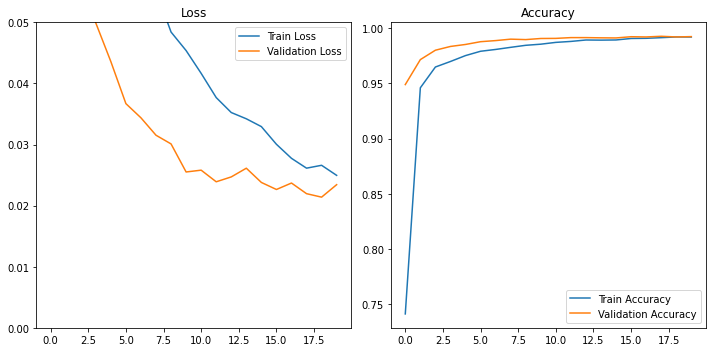

In [ ]:
plot_result(hist, 0, 0.05)

##### 최종검증

In [ ]:
loss, acc = model.evaluate(test_dataset)
print(loss, acc)

10/10 [==============================] - 0s 8ms/step - loss: 0.0234 - accuracy: 0.9923
0.023431148380041122 0.9922999739646912


## prediction error가 발생한 data 확인
- test dataset으로 예측한 결과중 틀린 것들을 확인해 본다.

In [ ]:
X_test.shape

(10000, 28, 28, 1)

In [ ]:
pred = model.predict(X_test)
pred.shape

313/313 [==============================] - 1s 4ms/step


(10000, 10)

In [ ]:
label = np.argmax(pred, axis=-1)   #모델이 추론한 label
print(label.shape)
label[:5]

(10000,)


array([7, 2, 1, 0, 4])

In [ ]:
# 모델이 추론한 결과중 정답과 다른 것의 index를 조회

In [ ]:
fail_idx = np.where(test_label != label)[0]
fail_idx.size

77

##### confusion matrix 확인

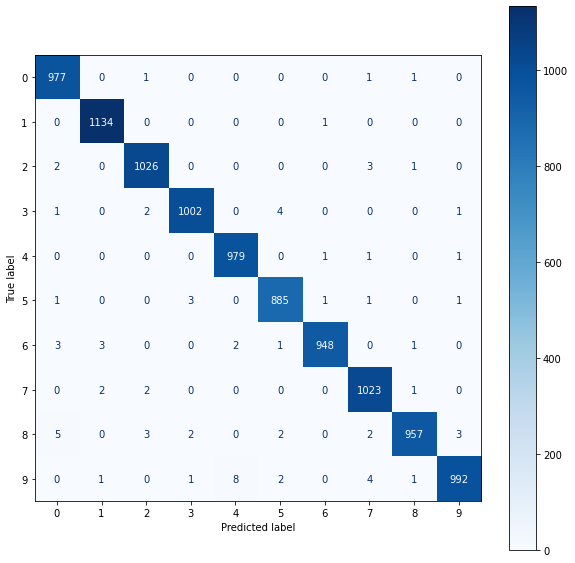

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(10,10))
ax = plt.gca() #크게 보려고 설정

cm = confusion_matrix(test_label, label)
dis = ConfusionMatrixDisplay(cm)
dis.plot(cmap="Blues", ax=ax)
plt.show()

8


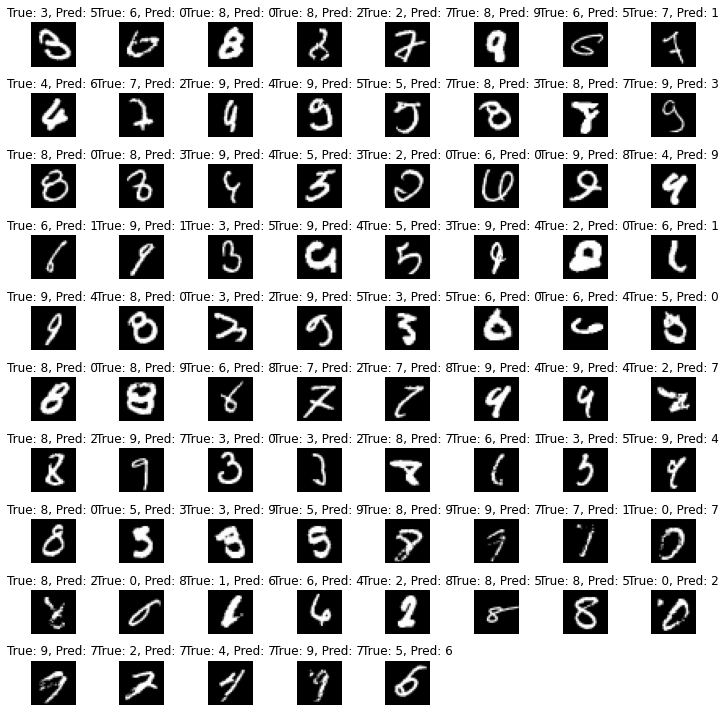

In [ ]:
# 틀린 이미지 출력
plt.figure(figsize=(10,10))
rows = int(np.ceil(fail_idx.size/10)) # 10개 행 만듦
print(rows)

for i in range(int(fail_idx.size)):   # 틀린 것 개수만큼 반복
  error_idx = fail_idx[i]
  pred_label = label[error_idx] # 틀린 것에 대해 모델이 예측한 라벨
  true_label = test_label[error_idx] # 틀린 것에 대한 정답 라벨
  img = test_image[error_idx]

  plt.subplot(10, rows, i+1)
  plt.imshow(img, cmap="gray")
  plt.title(f"True: {true_label}, Pred: {pred_label}")
  plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
path = "/content/drive/MyDrive/06_딥러닝/mnist_cnn"
model.save(path)

In [ ]:
path = "/content/drive/MyDrive/06_딥러닝/mnist_cnn"
saved_model = models.load_model(path)

In [ ]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

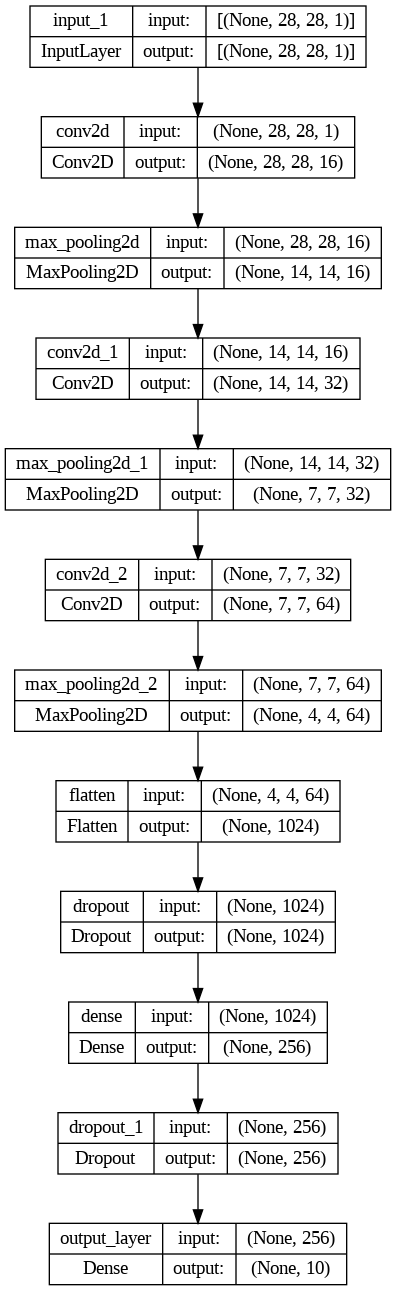

In [ ]:
keras.utils.plot_model(saved_model, show_shapes=True)

In [ ]:
saved_model.evaluate(test_dataset)

10/10 [==============================] - 0s 9ms/step - loss: 0.0234 - accuracy: 0.9923


[0.023431148380041122, 0.9922999739646912]

# 학습한 모델 파일로 저장

- **무엇을 저장할 지**
    1. Train이 끝난 모델의 파라미터만 저장
    1. 모델 구조와 파라미터 모두 저장

- **저장시점**
    1. Train 완료된 모델을 저장
    1. Callback을 이용해 Train 도중 가장 성능이 좋은 시점의 모델을 저장

## 텐서플로 저장 파일 타입
- checkpoint 
    - 모델의 weight를 저장하기 위한 타입
- SavedModel 
    - 모델의 구조와 파라미터들을 모두 저장하는 타입

## 학습한 Weight (파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.
- 저장
    - `model.save_weights("저장경로")`
- 불러오기
    - `model.load_weights('불러올경로')`
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`
        - 또는 파일 확장자를 h5로 지정한다.

In [ ]:
# 저장할 디렉토리 생성
import os
SAVE_ROOT_PATH = "/content/drive/MyDrive/Colab Notebooks"
SAVE_MODEL_PATH = os.path.join(SAVE_ROOT_PATH, 'saved_models')
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)
print(os.path.isdir(SAVE_MODEL_PATH))

True


In [ ]:
# MODEL의 파라미터들만 저장. => model.save_weight(저장파일경로)
MNIST_WEIGHTS_DIR_PATH = os.path.join(SAVE_MODEL_PATH, 'mnist_cnn_weights')
os.makedirs(MNIST_WEIGHTS_DIR_PATH, exist_ok=True)
MNIST_WEIGHTS_FILE_PATH = os.path.join(MNIST_WEIGHTS_DIR_PATH, 'ckpt')  # 파일경로

In [ ]:
saved_model.save_weights(MNIST_WEIGHTS_FILE_PATH)

In [ ]:
# 저장된 WEIGHT를 LOADING해서 모델을 RESTORE
# 1. 모델을 생성
saved_model2 = get_mnist_cnn_model(LEARNING_RATE)
saved_model2.evaluate(test_dataset)

10/10 [==============================] - 0s 8ms/step - loss: 2.3052 - accuracy: 0.0748


[2.305156946182251, 0.07479999959468842]

In [ ]:
#2. 생성한 모델에 weight를 덮어씌운다.
saved_model2.load_weights(MNIST_WEIGHTS_FILE_PATH)
saved_model2.evaluate(test_dataset)

10/10 [==============================] - 0s 7ms/step - loss: 0.0234 - accuracy: 0.9923


[0.023431148380041122, 0.9922999739646912]

## 전체 모델 저장하고 불러오기
- https://www.tensorflow.org/guide/keras/save_and_serialize?hl=ko
- 저장
    - `model.save('저장할디렉토리')`
- 불러오기
    - `tf.keras.models.load_model('저장된디렉토리')`
- 저장 형식
    - Tensorflow **SavedModel** 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')` 
        - 또는 파일의 확장자를 h5로 지정한다.

In [ ]:
MNIST_MODEL_PATH = os.path.join(SAVE_MODEL_PATH, 'mnist_model')  # 모델을 저장할 경우 디렉토리 경로를 지정.

In [ ]:
saved_model.save(MNIST_MODEL_PATH)

In [ ]:
saved_model3 = tf.keras.models.load_model(MNIST_MODEL_PATH)
saved_model3.evaluate(test_dataset)

## Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- 다양한 콜백 클래스가 제공된다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- ### ModelCheckpoint
    - 각 epoch 마다 학습한 모델과 weight(또는 weight만)를 저장한다. 
    - 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight만 저장할 수 있다.
    - 주요 파라미터
        - `save_weights_only=True`: True: 파라미터(weight)만 저장한다. False: 모델구조와 파라미터 모두 저장한다.
        - `save_best_only=True`: 학습중 성능이 개선될 때만 저장한다. (False:기본값 - 모든 에폭마다 저장한다.)
- ### EarlyStopping
    - Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈추는 callback
    - 주요 파라미터
        - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
        - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다. 

- **callback 객체들을 리스트로 묶은 뒤 fit()의 callbacks 매개변수에 전달한다.**

In [ ]:
#  모델생성
model2 = get_mnist_cnn_model(LEARNING_RATE)

In [ ]:
# CALLBACK 
#  MNIST_MODEL_CALLBACK_{epoch:04d}
SAVE_PATH = os.path.join(SAVE_MODEL_PATH, 'MNIST_MODEL_CALLBACK_{epoch:04d}')  # 모델 구조 + 파라미터
mc_callback = keras.callbacks.ModelCheckpoint(filepath=SAVE_PATH, # 저장할 경로
                                              save_best_only=True, # True: 성능이 개선된 경우만 저장. False(기본): 매 epoch마다 저장
                                              monitor='val_loss', # save_best_only=True 했을때 확인 할 성능지표
                                              verbose=1 # 저장할때 마다 로그를 출력
                                              )

early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', # 확인할 성능 지표
                                                    patience=5, # 개선 여부를 기다릴 에폭수  
                                                    verbose=1
                                                    )

hist = model2.fit(train_dataset, epochs=100, validation_data=test_dataset, 
                  callbacks=[mc_callback, early_stop_callback])

In [ ]:
# 저장된 모델을 loading
saved_model4 = models.load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/MNIST_MODEL_CALLBACK_0035")
saved_model4.evaluate(test_dataset)

In [ ]:
# weight 만 저장
model4 = get_mnist_cnn_model(LEARNING_RATE)

SAVE_PATH = os.path.join(SAVE_MODEL_PATH, 'MNIST_WEIGHTS_CALLBACK/ckpt')  #  파라미터 => 파일경로
mc_callback = keras.callbacks.ModelCheckpoint(filepath=SAVE_PATH, # 저장할 경로
                                              save_best_only=True, # True: 성능이 개선된 경우만 저장. False(기본): 매 epoch마다 저장
                                              monitor='val_loss', # save_best_only=True 했을때 확인 할 성능지표
                                              verbose=1, # 저장할때 마다 로그를 출력
                                              save_weights_only=True,  # True: 파라미터만 저장. False(기본): 모델+파라미터저장.
                                              )

early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', # 확인할 성능 지표
                                                    patience=5, # 개선 여부를 기다릴 에폭수  
                                                    verbose=1
                                                    )

hist = model4.fit(train_dataset, epochs=100, validation_data=test_dataset, 
                  callbacks=[mc_callback, early_stop_callback])

In [ ]:
saved_model5 = get_mnist_cnn_model(LEARNING_RATE)
saved_model5.load_weights(SAVE_PATH)

In [ ]:
saved_model5.evaluate(test_dataset)

###### best weight 호출 2

- tf.train.latest_checkpoint(체크포인트가 있는 경로). 그 경로에 가장 늦게 저장된 checkpoint 파일 경로 반환
    - best 말고 모든 epoch별로 저장한 경우 사용
```python
best_weight_path = tf.train.latest_checkpoint(checkpoint_save_file) #디렉토리까지만 넣는다.
best_weight_path
```